## Visualisation of excess mortality over Europe in 2020 using _Eurostat_ data

Prepared by [**J.Grazzini**](mailto:jacopo.grazzini@ec.europa.eu) ([**Eurostat**](https://ec.europa.eu/eurostat), Methodology & Innnovation unit B.1).

The purpose of this notebook is to dynamically generate maps of weekly excess mortality over Europe NUTS2 or NUTS3 regions, depending on their availability.

**Data sources:** 

* _Eurostat_ data on _"Deaths by age group, sex, week and NUTS 3 region"_ [demo_r_mweek3](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mweek3&lang=en),
* _Eurostat_ data on _"Deaths by week and sex"_ [demo_r_mwk_ts](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mwk_ts&lang=en) (not used here),
* _Eurostat_ geographical data on regional units NUTS 2016 (see [GISCO website](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts)).

**Main outcomes:**

We compute the spatial (continental Europe at NUTS level 3) and temporal (over a short time period, from 24/02/20 to 26/04/20) distribution of excess mortality, and visualise the figures as: 
* [static map](#MapAggregated) over the aggregate period,
* [individual statics maps](#Maps) for every single week in the considered period,
* ibid, but [overlayed dynamic maps](#MapsOverlay) are displayed,  
* ibid, a [time slider of the static maps](#MapsSlider) is made available.

**Notes:**

* We provide here with some quick and dirty material to fetch the data from the provider (*e.g.*, in a bulk manner, not using the API) and compute basic descriptive statistics (*e.g.*, an excess indice/rate). This will need to be improved in order to further automate it.
* On June 24th, 2020, Eurostat released a press article on [2020 data on weekly deaths](https://ec.europa.eu/eurostat/web/products-eurostat-news/-/DDN-20200624-1?inheritRedirect=true&redirect=%2Feurostat%2F). 
* On June 26th, 2020, Eurostat released a *Statistics Explained* article on [weekly death statistics](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics&stable).
* This notebook was created on May 13th, 2020 and was **updated on June 28th, 2020**. While the initial results reported excess death rates ($100\times\frac{D - D_{\text{base}}}{D_{\text{base}}}$), the calculations have been updated so as to provide now "base-100" excess death indices ($100\times\frac{D}{D_{\text{base}}}$) similar to what is presented in the *Statistics Explained* article mentioned above. 
* The data analysed in this notebook are fetched from [_Eurostat_ online database](https://ec.europa.eu/eurostat/data/database) on the date of the last run.

### Settings

In [1]:
from datetime import datetime
print("Last update/running of this notebook: \033[1m%s\033[0m" % datetime.today())

Last update/running of this notebook: 2020-06-29 18:04:00.374892


In [2]:
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_)

Current working directory: ['/Users/gjacopo/DevOps/mortality-viz']


Let's import all we need, starting with the basic packages:

In [3]:
import requests
import io, os, re, sys
import warnings
import copy, functools
import zipfile

as well as common data handling mocdules `pandas` and `numpy`:

In [4]:
import json

import pandas as pd
pd.set_option('mode.chained_assignment', None) # ignore SettingWithCopyWarning
import numpy as np

We also perform all geometric/set operations of vector layers using the `geopandas` package:

In [5]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        import geopandas as gpd
finally:
    warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

try:
    from shapely import geometry
except ImportError:
    try:
        !{sys.executable} -m pip install shapely
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        from shapely import geometry

For visualisation purpose, the package `matplotlib` is used:

In [6]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
finally:
    _FIGSIZE_, _DPI_ = (7,4), 140 # just some default display size/resolution inside this notebook...
%matplotlib inline

Last, for interactive mapping, we use `folium` while `branca` is used for building a colormpa similar to that of the *Statistics Explained* article mentioned above:

In [7]:
try:
    import folium
except ImportError:
    try:
        !{sys.executable} -m pip install folium
    except:
        print("! Package folium not installed !")
    else:
        print("! Package folium installed on-the-fly !")
        import folium
finally:
    from folium import plugins as foliump

try:
    import branca
except ImportError:
    try:
        !{sys.executable} -m pip install branca
    except:
        print("! Package branca not installed !")
    else:
        print("! Package branca installed on-the-fly !")
finally:
    import branca.colormap as bcm

### (Dirty) data ingestion

Data on death figures will be fetched from [Eurostat bulk website](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=data). The link to the data source in TSV format is : https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz. 

In [8]:
bulk_domain = 'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1'
death_file = 'demo_r_mweek3'
death_ext = 'tsv.gz'
death_url = '{}&file=data%2F{}.{}'.format(bulk_domain, death_file, death_ext)

print("URL for death data: \033[1m%s\033[0m" % death_url)

URL for death data: https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz


In [9]:
death_source = '%s.%s' % (death_file, death_ext)

try : 
    dest = os.path.join(_THISDIR_[0], ('.').join(death_source.split('.')[:-1]))
    assert os.path.exists(dest)
except:
    try:
        !wget -O $death_source "$death_url"
        !gunzip -f $death_source
    except:
        raise IOError("Error fetching & unzipping the data...")
    else:
        print('Data are loaded on disk in \033[1m%s\033[0m' % dest)
else:
    print('Data alredy on disk in \033[1m%s\033[0m' % dest)
finally:
    death_ext = death_ext.split('.')[0]
    death_source = dest

--2020-06-29 18:04:05--  https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz
Resolving ec.europa.eu (ec.europa.eu)... 2a01:7080:24:100::666:30, 2a01:7080:14:100::666:30, 147.67.210.30, ...
Connecting to ec.europa.eu (ec.europa.eu)|2a01:7080:24:100::666:30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20184820 (19M) [application/octet-stream]
Saving to: ‘demo_r_mweek3.tsv.gz’

demo_r_mweek3.tsv.g 100%[===================>]  19.25M  3.53MB/s    in 5.4s    

2020-06-29 18:04:11 (3.55 MB/s) - ‘demo_r_mweek3.tsv.gz’ saved [20184820/20184820]

Data are loaded on disk in /Users/gjacopo/DevOps/mortality-viz/demo_r_mweek3.tsv


Ibid with the geographical resources that you can retrieve from GISCO API, *e.g.* [https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip](https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip):

In [10]:
gisco_domain = 'https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download'
nuts_year = 2016
nuts_res = 60
nuts_file = 'ref-nuts-%s-%sm' % (nuts_year, nuts_res) 
nuts_ext = 'geojson.zip'
nuts_url = '%s/%s.%s' %  (gisco_domain, nuts_file, nuts_ext)

print("URL for geographical data: \033[1m%s\033[0m" % nuts_url)

URL for geographical data: https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip


In [11]:
nuts_source = '%s.%s' % (nuts_file, nuts_ext)
nuts_dir = 'NUTS' 

try : 
    dest = os.path.join(_THISDIR_[0],nuts_dir)
    assert os.path.exists(dest)
except:
    try:
        !wget -O $nuts_source "$nuts_url"
        !mkdir $nuts_dir
        !unzip -u -d $nuts_dir $nuts_source        
    except:
        raise IOError("Error fetching & unzipping the data...")
    else:
        print('Data are loaded on disk in directory: \033[1m%s\033[0m' % dest)
else:
    print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest)
finally:
    nuts_ext = nuts_ext.split('.')[0]
    nuts_source = nuts_dir

--2020-06-29 18:04:14--  https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip
Resolving ec.europa.eu (ec.europa.eu)... 2a01:7080:24:100::666:30, 2a01:7080:14:100::666:30, 147.67.210.30, ...
Connecting to ec.europa.eu (ec.europa.eu)|2a01:7080:24:100::666:30|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gisco-services.ec.europa.eu/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip [following]
--2020-06-29 18:04:15--  https://gisco-services.ec.europa.eu/distribution/v2/nuts/download/ref-nuts-2016-60m.geojson.zip
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2588622 (2.5M) [application/zip]
Saving to: ‘ref-nuts-2016-60m.geojson.zip’

ref-nuts-2016-60m.g 100%[===================>]   2.4

Fetch the URL to get the response:

### Data preparation

We first explore the [NUTS data](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). Actually we consider NUTS region boundaries at all levels (`LEVELS`), from 0 to 3, since some data are available at country level. Hence we 'store' one vector dataset per NUTS level (`nuts_data`): 

In [12]:
LEVELS = [0,1,2,3]

files = dict.fromkeys(LEVELS)
[files.update({l: 'NUTS_RG_%sM_%s_3035_LEVL_%s.%s' % (nuts_res, nuts_year, l, nuts_ext)}) 
 for l in LEVELS]

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0],nuts_source,files[l]), driver='GeoJSON')}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

nuts_data[LEVELS[1]].head(5)

Geographical datasets: ['NUTS_RG_60M_2016_3035_LEVL_0.geojson', 'NUTS_RG_60M_2016_3035_LEVL_1.geojson', 'NUTS_RG_60M_2016_3035_LEVL_2.geojson', 'NUTS_RG_60M_2016_3035_LEVL_3.geojson'] loaded
Projection: epsg:3035


id  COAST_TYPE  MOUNT_TYPE CNTR_CODE  FID NUTS_ID           NUTS_NAME  \
0  HU1           0           0        HU  HU1     HU1  KÖZÉP-MAGYARORSZÁG   
1  HU2           0           0        HU  HU2     HU2            DUNÁNTÚL   
2  HU3           0           0        HU  HU3     HU3     ALFÖLD ÉS ÉSZAK   
3  CY0           0           0        CY  CY0     CY0              ΚΥΠΡΟΣ   
4  CZ0           0           0        CZ  CZ0     CZ0     ČESKÁ REPUBLIKA   

   LEVL_CODE  URBN_TYPE                                           geometry  
0          1          0  POLYGON ((5046179.000 2766903.000, 5086597.000...  
1          1          0  POLYGON ((4897845.000 2768465.000, 4912120.000...  
2          1          0  POLYGON ((5214660.000 2880854.000, 5216710.000...  
3          1          0  MULTIPOLYGON (((6467380.000 1643362.000, 64132...  
4          1          0  POLYGON ((4635755.000 3113255.000, 4645979.000...

Let's have a "quick" render of the NUTS data: 

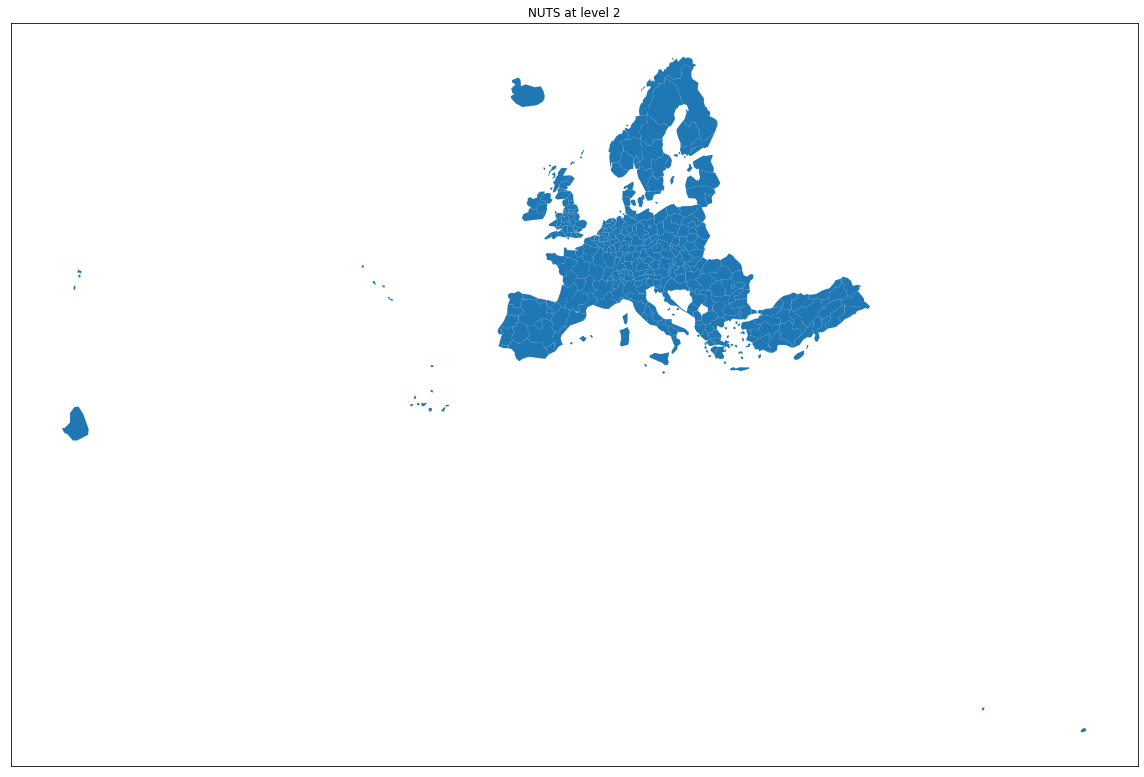

In [13]:
level = LEVELS[2]

f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('NUTS at level %s' % level) 
f.tight_layout()
mplt.show()

Following, we also integrate the mortality data (`death_data`):

In [14]:
death_data = pd.read_csv(death_source, sep='\t',encoding='latin1')

print('Dimensions of the table: %s' % list(death_data.shape))
death_data.head(5)

Dimensions of the table: [67038, 1069]


unit,sex,age,geo\time 2020W25  2020W24  2020W23  2020W22  2020W21  2020W20   \
0         NR,F,TOTAL,AT       :        :        :     729 p    724 p    735 p   
1        NR,F,TOTAL,AT1       :        :        :     343 p    328 p    328 p   
2       NR,F,TOTAL,AT11       :        :        :      26 p     28 p     29 p   
3       NR,F,TOTAL,AT12       :        :        :     162 p    152 p    164 p   
4       NR,F,TOTAL,AT13       :        :        :     155 p    148 p    135 p   

  2020W19  2020W18  2020W17   ... 2000W10  2000W09  2000W08  2000W07   \
0    748 p    759 p    791 p  ...     834      874      908      914    
1    355 p    355 p    350 p  ...     390      418      447      446    
2     25 p     41 p     25 p  ...      33       41       37       32    
3    165 p    157 p    174 p  ...     168      186      179      182    
4    165 p    157 p    151 p  ...     189      191      231      232    

  2000W06  2000W05  2000W04  2000W03  2000W02  2000W01   
0     967     1071     1076     1141     1062     1053   
1     428      496      501      596      577      545   
2      37       40       42       39       53       35   
3     184      208      205      251      225      225   
4     207      248      254      306      299      285   

[5 rows x 1069 columns]

We retrieve some basic info, *e.g.* the number of weekly acquisitions available (`WEEK_COLS`), the temporal coverage (`YEARS`), including the current/last one (`YCUR`) and weeks covered (`WEEKS`) during that year:

In [15]:
WEEK_COLS = [col for col in death_data.columns if re.search('W',col) is not None]
print('Number of weekly observations: %s' % len(WEEK_COLS))

YEARS = list(set([int(col.split('W')[0]) for col in WEEK_COLS]))
print("Years present in the dataset: \033[1m%s\033[0m" % YEARS)

YCUR = max(YEARS)
print("Current year: \033[1m%s\033[0m" % YCUR)

WEEKS = list(set([int(col.split('W')[1]) for col in WEEK_COLS if col.startswith(str(YCUR))]))
print("Weeks available in current year: \033[1m%s\033[0m" % WEEKS)

Number of weekly observations: 1068
Years present in the dataset: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Current year: 2020
Weeks available in current year: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


Say that we are looking to a specific period, we know already that we will not be using all the data. In that case we specify the starting year (`YSTART`) of the study. All data collected before that date will be discarded:

In [16]:
YSTART = 2016

try:
    assert YSTART in YEARS
except:
    raise IOError("Select another start year in \033[1m%s\033[0m" % YEARS)
else:
    CYEARS, RYEARS = range(YSTART,max(YEARS)), range(YSTART,max(YEARS)+1)

DISCARD_COLS = [col for col in WEEK_COLS if int(col.split('W')[0])<YSTART]
COLUMNS = [col for col in death_data.columns if not re.search('W', col) or int(col.split('W')[0])>=YSTART]

WEEK_COLS = list(set(WEEK_COLS).difference(set(DISCARD_COLS)))
print('Updated number of quarterly observations: %s' % len(WEEK_COLS))

if len(DISCARD_COLS) < len(COLUMNS):
    death_data.drop(columns=DISCARD_COLS, inplace=True)
else:
    death_data = death_data[COLUMNS]
    
print("Updated list of variables considered for this analysis: \033[1m%s\033[0m" 
      % COLUMNS) # % list(death_data.columns)

Updated number of quarterly observations: 233
Updated list of variables considered for this analysis: ['unit,sex,age,geo\\time', '2020W25 ', '2020W24 ', '2020W23 ', '2020W22 ', '2020W21 ', '2020W20 ', '2020W19 ', '2020W18 ', '2020W17 ', '2020W16 ', '2020W15 ', '2020W14 ', '2020W13 ', '2020W12 ', '2020W11 ', '2020W10 ', '2020W09 ', '2020W08 ', '2020W07 ', '2020W06 ', '2020W05 ', '2020W04 ', '2020W03 ', '2020W02 ', '2020W01 ', '2019W52 ', '2019W51 ', '2019W50 ', '2019W49 ', '2019W48 ', '2019W47 ', '2019W46 ', '2019W45 ', '2019W44 ', '2019W43 ', '2019W42 ', '2019W41 ', '2019W40 ', '2019W39 ', '2019W38 ', '2019W37 ', '2019W36 ', '2019W35 ', '2019W34 ', '2019W33 ', '2019W32 ', '2019W31 ', '2019W30 ', '2019W29 ', '2019W28 ', '2019W27 ', '2019W26 ', '2019W25 ', '2019W24 ', '2019W23 ', '2019W22 ', '2019W21 ', '2019W20 ', '2019W19 ', '2019W18 ', '2019W17 ', '2019W16 ', '2019W15 ', '2019W14 ', '2019W13 ', '2019W12 ', '2019W11 ', '2019W10 ', '2019W09 ', '2019W08 ', '2019W07 ', '2019W06 ', '2019W0

Since we also notice the columns' names include blanks, we reformat them (while we update the list):

In [17]:
death_data.rename(columns=lambda x: x.strip(), inplace=True)
# print("Stripped data column names are: \033[1m%s\033[0m" % list(death_data.columns))

WEEK_COLS = [col.strip() for col in WEEK_COLS]

In tsv format the indexing variables are actually merged in the first column (`'unit,sex,age,geo\\time'`). Let's reformat the dataset (`tsv_prepare`):

In [18]:
def tsv_prepare(df):
    first_col = df.columns[0]
    cols = first_col.split('\\')[0].split(',')
    def split_column(col):
        return col.split(',')
    df[cols] = df.apply(lambda row: pd.Series(split_column(row[first_col])), axis=1)
    return df.drop(columns=first_col)

death_data = tsv_prepare(death_data)
# print("Data column names are: \033[1m%s\033[0m" % list(death_data.columns))

death_data.head(5)

2020W25 2020W24 2020W23 2020W22 2020W21 2020W20 2020W19 2020W18 2020W17  \
0      :       :       :    729 p   724 p   735 p   748 p   759 p   791 p   
1      :       :       :    343 p   328 p   328 p   355 p   355 p   350 p   
2      :       :       :     26 p    28 p    29 p    25 p    41 p    25 p   
3      :       :       :    162 p   152 p   164 p   165 p   157 p   174 p   
4      :       :       :    155 p   148 p   135 p   165 p   157 p   151 p   

  2020W16  ... 2016W06 2016W05 2016W04 2016W03 2016W02 2016W01 unit sex  \
0   903 p  ...    882     836     857     814     823     853    NR   F   
1   406 p  ...    402     392     395     347     380     387    NR   F   
2    42 p  ...     28      31      42      26      38      32    NR   F   
3   175 p  ...    206     181     178     156     167     160    NR   F   
4   189 p  ...    168     180     175     165     175     195    NR   F   

     age   geo  
0  TOTAL    AT  
1  TOTAL   AT1  
2  TOTAL  AT11  
3  TOTAL  AT12  
4  TOTAL  AT13  

[5 rows x 237 columns]

We also retrieve available regions (`REGIONS`):

In [19]:
REGIONS = death_data['geo'].unique().tolist()

print("NUTS regions available: \033[1m%s\033[0m" % REGIONS)

NUTS regions available: ['AT', 'AT1', 'AT11', 'AT12', 'AT13', 'AT2', 'AT21', 'AT22', 'AT3', 'AT31', 'AT32', 'AT33', 'AT34', 'BE', 'BE1', 'BE10', 'BE100', 'BE2', 'BE21', 'BE211', 'BE212', 'BE213', 'BE22', 'BE221', 'BE222', 'BE223', 'BE23', 'BE231', 'BE232', 'BE233', 'BE234', 'BE235', 'BE236', 'BE24', 'BE241', 'BE242', 'BE25', 'BE251', 'BE252', 'BE253', 'BE254', 'BE255', 'BE256', 'BE257', 'BE258', 'BE3', 'BE31', 'BE310', 'BE32', 'BE321', 'BE322', 'BE323', 'BE324', 'BE325', 'BE326', 'BE327', 'BE33', 'BE331', 'BE332', 'BE334', 'BE335', 'BE336', 'BE34', 'BE341', 'BE342', 'BE343', 'BE344', 'BE345', 'BE35', 'BE351', 'BE352', 'BE353', 'BG', 'BG3', 'BG31', 'BG311', 'BG312', 'BG313', 'BG314', 'BG315', 'BG32', 'BG321', 'BG322', 'BG323', 'BG324', 'BG325', 'BG33', 'BG331', 'BG332', 'BG333', 'BG334', 'BG34', 'BG341', 'BG342', 'BG343', 'BG344', 'BG4', 'BG41', 'BG411', 'BG412', 'BG413', 'BG414', 'BG415', 'BG42', 'BG421', 'BG422', 'BG423', 'BG424', 'BG425', 'CH', 'CH0', 'CH01', 'CH011', 'CH012', 'CH013

We need to further clean the data to get rid of the flags (note: *this is actually important, and should be communicated with the data*, however we omit it for this exercise). We also reformat missing values (`:`) into NaNs (`flag_nan_clean`):

In [20]:
def flag_nan_clean(df):
    def filter_cell(c):
        cstr = str(c)
        return np.nan if cstr.strip()==':' else (np.float(c.split(' ')[0]) if re.search(' ', cstr) else c)
    return df.applymap(filter_cell)

death_data = flag_nan_clean(death_data) # Zzzzzzz...

death_data.head(5)

2020W25  2020W24  2020W23  2020W22  2020W21  2020W20  2020W19  2020W18  \
0      NaN      NaN      NaN    729.0    724.0    735.0    748.0    759.0   
1      NaN      NaN      NaN    343.0    328.0    328.0    355.0    355.0   
2      NaN      NaN      NaN     26.0     28.0     29.0     25.0     41.0   
3      NaN      NaN      NaN    162.0    152.0    164.0    165.0    157.0   
4      NaN      NaN      NaN    155.0    148.0    135.0    165.0    157.0   

   2020W17  2020W16  ...  2016W06  2016W05  2016W04  2016W03  2016W02  \
0    791.0    903.0  ...    882.0    836.0    857.0    814.0    823.0   
1    350.0    406.0  ...    402.0    392.0    395.0    347.0    380.0   
2     25.0     42.0  ...     28.0     31.0     42.0     26.0     38.0   
3    174.0    175.0  ...    206.0    181.0    178.0    156.0    167.0   
4    151.0    189.0  ...    168.0    180.0    175.0    165.0    175.0   

   2016W01  unit  sex    age   geo  
0    853.0    NR    F  TOTAL    AT  
1    387.0    NR    F  TOTAL   AT1  
2     32.0    NR    F  TOTAL  AT11  
3    160.0    NR    F  TOTAL  AT12  
4    195.0    NR    F  TOTAL  AT13  

[5 rows x 237 columns]

Last, we cast the data:

In [21]:
death_data[WEEK_COLS] = death_data[WEEK_COLS].astype(float)

death_data.head(5)

2020W25  2020W24  2020W23  2020W22  2020W21  2020W20  2020W19  2020W18  \
0      NaN      NaN      NaN    729.0    724.0    735.0    748.0    759.0   
1      NaN      NaN      NaN    343.0    328.0    328.0    355.0    355.0   
2      NaN      NaN      NaN     26.0     28.0     29.0     25.0     41.0   
3      NaN      NaN      NaN    162.0    152.0    164.0    165.0    157.0   
4      NaN      NaN      NaN    155.0    148.0    135.0    165.0    157.0   

   2020W17  2020W16  ...  2016W06  2016W05  2016W04  2016W03  2016W02  \
0    791.0    903.0  ...    882.0    836.0    857.0    814.0    823.0   
1    350.0    406.0  ...    402.0    392.0    395.0    347.0    380.0   
2     25.0     42.0  ...     28.0     31.0     42.0     26.0     38.0   
3    174.0    175.0  ...    206.0    181.0    178.0    156.0    167.0   
4    151.0    189.0  ...    168.0    180.0    175.0    165.0    175.0   

   2016W01  unit  sex    age   geo  
0    853.0    NR    F  TOTAL    AT  
1    387.0    NR    F  TOTAL   AT1  
2     32.0    NR    F  TOTAL  AT11  
3    160.0    NR    F  TOTAL  AT12  
4    195.0    NR    F  TOTAL  AT13  

[5 rows x 237 columns]

### Data exploration

For reminder:

In [22]:
print('Number of weekly observations: %s' % len(WEEK_COLS))
print("Years present in the dataset: \033[1m%s\033[0m" % YEARS)
print("Current year: \033[1m%s\033[0m" % YCUR)
print("Weeks available in current year: \033[1m%s\033[0m" % WEEKS)

Number of weekly observations: 233
Years present in the dataset: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
Current year: 2020
Weeks available in current year: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


We first have a look at which data/countries (`DATA_NUTS_ID`) are actually made available throughout the dataset `death_date` (note that this actually does not specify whether the data are `NaN` or not...):

In [23]:
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = death_data['geo'].unique().tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: ['LU', 'NO', 'PT', 'IS', 'LI', 'NL', 'ME', 'IT', 'HU', 'AT', 'BE', 'FR', 'EE', 'UK', 'DK', 'CZ', 'ES', 'HR', 'CH', 'FI', 'DE', 'LV', 'SI', 'BG', 'SK', 'LT', 'RS', 'SE']
* NUTS level 1: ['LU', 'NO', 'PT', 'IS', 'LI', 'NL', 'ME', 'IT', 'HU', 'AT', 'BE', 'FR', 'EE', 'UK', 'DK', 'CZ', 'ES', 'CH', 'FI', 'LV', 'BG', 'SK', 'LT', 'RS', 'SE']
* NUTS level 2: ['LU', 'NO', 'PT', 'IS', 'LI', 'NL', 'ME', 'IT', 'HU', 'AT', 'BE', 'FR', 'EE', 'UK', 'DK', 'CZ', 'ES', 'CH', 'FI', 'LV', 'BG', 'SK', 'LT', 'RS', 'SE']
* NUTS level 3: ['LU', 'NO', 'PT', 'IS', 'LI', 'NL', 'ME', 'IT', 'HU', 'BE', 'FR', 'EE', 'UK', 'DK', 'CZ', 'ES', 'CH', 'FI', 'LV', 'BG', 'SK', 'LT', 'RS', 'SE']


We can see for any given level, which country/datasets are missing:

In [24]:
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['EL', 'MK', 'RO', 'MT', 'CY', 'AL', 'TR', 'PL', 'IE']
* NUTS level 1: ['DE', 'SI', 'HR', 'EL', 'MK', 'RO', 'MT', 'CY', 'AL', 'TR', 'PL', 'IE']
* NUTS level 2: ['DE', 'SI', 'HR', 'EL', 'MK', 'RO', 'MT', 'CY', 'AL', 'TR', 'PL', 'IE']
* NUTS level 3: ['AT', 'DE', 'SI', 'HR', 'EL', 'MK', 'RO', 'MT', 'CY', 'AL', 'TR', 'PL', 'IE']


We can also build (using the method `time_series`) the temporal evolution of the death indice/rate for a given region (`REG_ID`) and store it in a time series (`ts`):

In [25]:
def time_series(df, geo, age = "TOTAL", sex = "T", week = 1, years = [2020,]):
    try:
        assert isinstance(df, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    if np.isscalar(week): 
        week = [week,]
    ts = pd.DataFrame(columns = [y for y in years], 
                      index = pd.Index(week))
    extract = (
        df.loc[(df["geo"]==geo) & (df["age"]==age) & (df["sex"]==sex)]
        .drop(columns=["geo","age","sex"])
    )
    for y in years:
        ts[y] = pd.Series(extract[["%sW%02d" % (y,w) for w in week]].values[0])
    return ts

REG_NAME = 'Lombardia'
REG_ID = nuts_data[2].loc[nuts_data[2]['NUTS_NAME']==REG_NAME, 'NUTS_ID'].values[0]

AGE, SEX = "TOTAL", "T"
ts = time_series(death_data, REG_ID, age = AGE, sex = SEX, 
                 week = WEEKS, years = RYEARS)

try: 
    assert ts is not None
except:
    print("\033[1m!!! No data available for the considered region !!!\033[0m")
else:
    print('Data available for unit %s (age: %s, sex: %s)' % (REG_ID, AGE, SEX))
ts is not None and ts.head(5)

Data available for unit ITC4 (age: TOTAL, sex: T)


2016    2017    2018    2019    2020
1  1994.0  2873.0  2510.0  2242.0  2029.0
2  2094.0  2684.0  2428.0  2284.0  2104.0
3  1969.0  2549.0  2271.0  2306.0  2123.0
4  1922.0  2328.0  2297.0  2411.0  2051.0
5  1979.0  2254.0  2061.0  2303.0  2113.0

that we plot (using `plot_oneversus`) for quick exploration:

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x153a63e50>)

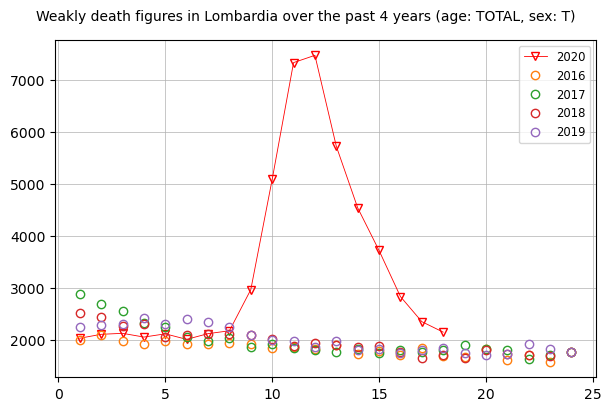

In [26]:
def plot_oneversus(df, index = None, one = None, versus = None,  
                   fig=None, ax=None, shp = (1,1), dpi=_DPI_,
                   xlabel='', ylabel='', title = '', xrottick = False, legend = None,                 
                   grid = False, suptitle = '', locator = None, formatter = None):    
    try:
        assert isinstance(df, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input timeseries')
    if ax is None:
        if shp in (None,[],()): shp = (1,1)
        if dpi is None:     fig, pax = mplt.subplots(*shp, constrained_layout=True)
        else:               fig, pax = mplt.subplots(*shp, dpi=dpi, constrained_layout=True)
        if isinstance(pax,np.ndarray):
            if pax.ndim == 1:    ax_ = pax[0]
            else:               ax_ = pax[0,0]
        else:
            ax_ = pax
    else:
        ax_, pax = ax, None
    if index is None:
        index = dat.index
    if one is not None:
        ax_.plot(df.loc[index,one], ls='-', lw=0.6, c='r', 
                 marker='v', markersize=6, fillstyle='none')
        next(ax_._get_lines.prop_cycler)
    if versus is None:
        versus = df.columns
        try:    versus.remote(one)
        except: pass
    ax_.plot(df.loc[index,versus], ls='None', marker='o', fillstyle='none')
    ax_.set_xlabel(xlabel), ax_.set_ylabel(ylabel)
    if grid is not False:       ax_.grid(linewidth=grid)
    if xrottick is not False:   ax_.tick_params(axis ='x', labelrotation=xrottick)
    if locator is not None:     ax_.xaxis.set_major_locator(locator)
    if formatter is not None:   ax_.xaxis.set_major_formatter(formatter)
    if legend is None:
        legend = [one]
        legend.extend(versus)
    ax_.legend(legend, fontsize='small')
    if title not in ('',None):  ax_.set_title(title,  fontsize='medium')
    if suptitle not in ('',None):       
        fig.suptitle(suptitle,  fontsize='medium')
    if pax is not None:
        return fig, pax
    
plot_oneversus(ts, index=WEEKS, one=YCUR, versus=CYEARS, dpi=100, grid = 0.5,
               suptitle="Weakly death figures in %s over the past %s years (age: %s, sex: %s)" 
                       % (REG_NAME, max(RYEARS)-min(RYEARS), AGE, SEX)
              )

### Excessive deaths representation

Let's further select an extended period of interest (`WEEKRES` as a list of weeks index):

In [27]:
DATERES, WEEKRES = None, list(range(9,18)) # select what you are interested
if WEEKRES is None:
    try:
        WEEKRES = DATERES.isocalendar()[1]
    except:
        WEEKRES = [15]

The method `estimate_excess_mortality` implements the estimation of both the excess rate and indice of deaths that occured during the selected period (`WEEKRES`) of the current year (`YCUR`). It is expressed as:
Considering the base reference $D_{\text{base}}$ taken as the mean (`BASE`, although $\max$ or $\min$ could also be used) of deaths calculated over the previous years (from `YSTART` to `YCUR` excluded), the method returns:
* either $r = \frac{D - D_{\text{base}}}{D_{\text{base}}}$ when `INDICE = "RATE"`,
* or $I = 100\times\frac{D}{D_{\text{base}}}$  when `INDICE = "I100"`,

where we obviously verify: $r = \frac{I - 100}{100}$

The output death excess indice/rate is stored in the `INC` column of the output dataset (`w_death_data`):

In [28]:
INDICE = 'I100' # 'RATE'

def estimate_excess_mortality(indice, df, inc = "rinc", agg = "mean", week=1, ystart=2015, year=2020):
    try:
        assert isinstance(indice,str) and indice in ('I100', 'RATE')
    except:
        raise IOError('wrong indice flag')
    try:
        assert isinstance(df,(pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    if np.isscalar(week): 
        week = [week,]
    col_drop = [col for col in death_data.columns 
                if re.search('W',col) is not None and int(col.split('W')[1]) not in week]
    data = df.drop(columns = col_drop)
    years = range(ystart, year)
    cols = [col for col in df.columns                               \
            if any([col.strip().endswith('W%02d' % w) for w in week]) \
            and int(col.split('W')[0]) in years]
    sagg = df[cols].agg(agg, axis='columns', skipna=False) # we cant ignore missing values!
    if len(week)>1:
        cols = [col for col in df.columns                               \
                if any([col.strip().endswith('W%02d' % w) for w in week]) \
                and col.startswith('%sW' % str(year))]
        syear = df[cols].mean(axis='columns', skipna=False) # take the mean 
    else:
        syear = df['%sW%02d' % (str(year),week[0])]
    if indice == 'RATE':
        data[inc] = 100 * syear.sub(sagg).div(sagg) # we still mulitply by 100...
    elif indice == 'I100':
        data[inc] = 100 * syear.div(sagg)            
    return data

BASE = "mean" # "max" # "min"
INC = 'rinc'
w_death_data = estimate_excess_mortality(INDICE, death_data, inc = INC, agg = BASE, 
                                         week = WEEKRES, ystart = YSTART, year = YCUR)

w_death_data.head()

2020W17  2020W16  2020W15  2020W14  2020W13  2020W12  2020W11  2020W10  \
0    791.0    903.0    910.0    924.0    897.0    927.0    856.0    887.0   
1    350.0    406.0    407.0    387.0    402.0    411.0    376.0    390.0   
2     25.0     42.0     29.0     45.0     46.0     37.0     28.0     46.0   
3    174.0    175.0    189.0    183.0    160.0    180.0    172.0    184.0   
4    151.0    189.0    189.0    159.0    196.0    194.0    176.0    160.0   

   2020W09  2019W17  ...  2016W13  2016W12  2016W11  2016W10  2016W09  unit  \
0    905.0    785.0  ...    833.0    780.0    802.0    843.0    888.0    NR   
1    390.0    343.0  ...    379.0    347.0    384.0    380.0    396.0    NR   
2     36.0     36.0  ...     35.0     36.0     46.0     32.0     38.0    NR   
3    180.0    159.0  ...    185.0    148.0    183.0    171.0    175.0    NR   
4    174.0    148.0  ...    159.0    163.0    155.0    177.0    183.0    NR   

   sex    age   geo        rinc  
0    F  TOTAL    AT  105.627991  
1    F  TOTAL   AT1  102.534965  
2    F  TOTAL  AT11  109.958848  
3    F  TOTAL  AT12   99.672336  
4    F  TOTAL  AT13  104.062910  

[5 rows x 50 columns]

Let's generate (using the method `build_table`) the statistics for the entire population during the specific period (`s_death_data`):

In [29]:
def build_table(df, inc = 'rinc', key='NUTS_ID', age = "TOTAL", sex = "T", miss_id = {}):
    try:
        assert isinstance(df, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    col_drop = list(set(df.columns).difference(set(['geo',inc])))
    data_miss = pd.DataFrame({key: miss_id[0].copy(), inc: np.nan})
    return pd.concat([(
        df.loc[(df["age"]==age) & (df["sex"]==sex)]
        .copy()
        .drop(columns=col_drop)
        #.dropna(axis='index', subset=[inc])
        .rename(columns={'geo':key})
        ),
        data_miss
        ], 
        axis=0, ignore_index=True
    )

s_death_data = build_table(w_death_data, inc = INC, key=KEY, 
                           age = AGE, sex = SEX, 
                           miss_id=MISSING_CTRY_ID)

s_death_data.head(-10)

NUTS_ID        rinc
0         AT  108.559312
1        AT1  107.704735
2       AT11  111.530398
3       AT12  105.654882
4       AT13  109.145854
...      ...         ...
1059   UKL21         NaN
1060   UKL22         NaN
1061   UKL23         NaN
1062   UKL24         NaN
1063     UKM         NaN

[1064 rows x 2 columns]

We assume completeness here, that is when an administrative unit $A$ is available at level $l$, all other units belonging to the same region than $A$ at previous level $l-1$ are also available at level $l$. We merge the information from both datasets `nuts_data` (where geometries are stored) and `s_death_data` (where excess death `INC` is calculated) into a single dataset `nuts_death_data`:

In [30]:
def build_unit_level(nuts, death, levels = [0, 1, 2, 3], key='NUTS_ID', how='inner'): 
    try:
        assert (isinstance(nuts, dict) 
                and all([isinstance(df,(gpd.GeoSeries, gpd.GeoDataFrame)) for df in nuts.values()])
                and set(nuts.keys()).difference(set(levels)) == set())
    except:
        raise IOError('wrong format for input data dictionary')
    data = dict.fromkeys(levels)
    for l in levels:
        temp = (nuts[l]
                .merge(death, on=key, how=how)
                #.dropna(axis='index', subset=[inc]) 
               )
        temp = temp[~(temp.geometry.is_empty | temp.geometry.isna())]
        temp.geometry = temp.geometry.buffer(0) # deal with invalid geometry
        data.update({l: temp})
    return data

nuts_death_data = build_unit_level(nuts_data, s_death_data, 
                                   levels = LEVELS, key = KEY, how='right') 

nuts_death_data[3].head()

id  COAST_TYPE  MOUNT_TYPE CNTR_CODE    FID NUTS_ID  \
0  CZ052         3.0         4.0        CZ  CZ052   CZ052   
1  CZ053         3.0         4.0        CZ  CZ053   CZ053   
2  CZ063         3.0         4.0        CZ  CZ063   CZ063   
3  CZ064         3.0         4.0        CZ  CZ064   CZ064   
4  CZ071         3.0         2.0        CZ  CZ071   CZ071   

              NUTS_NAME  LEVL_CODE  URBN_TYPE  \
0  Královéhradecký kraj        3.0        2.0   
1       Pardubický kraj        3.0        3.0   
2         Kraj Vysočina        3.0        3.0   
3     Jihomoravský kraj        3.0        2.0   
4        Olomoucký kraj        3.0        2.0   

                                            geometry        rinc  
0  POLYGON ((4752268.000 3079151.000, 4768791.000...   96.249115  
1  POLYGON ((4812157.000 2965656.000, 4782782.000...   94.146825  
2  POLYGON ((4782782.000 2960975.000, 4775982.000...  107.531493  
3  POLYGON ((4841158.000 2932184.000, 4851728.000...   97.784846  
4  POLYGON ((4849854.000 3042645.000, 4835136.000...  100.198965

However, we know that some countries are represented at higher level only (this also includes those small countries which do not have NUTS representation in the highest level, say Luxembourg for instance). In practice, we transfer (in the method `build_unit_level`) the information available about an administrative unit $A$ at level $l$ to the highest $l+1$. In doing so, we shall also pay special attention to the list of countries for which data are not available in the specific period considered here besides the missing ones, *i.e.* those not listed in the table (update of `nuts_death_data`):

In [31]:
def propagate_unit_level(data, levels = [0, 1, 2, 3], inc = 'rinc', key = 'NUTS_ID', miss_id = {}):
    try:
        assert (isinstance(data, dict) 
                and all([isinstance(df,(gpd.GeoSeries, gpd.GeoDataFrame)) for df in data.values()])
                and set(data.keys()).difference(set(levels)) == set())
    except:
        raise IOError('wrong format for input data dictionary')
    nan_ctry_id = copy.deepcopy(miss_id) or dict.fromkeys(levels) 
    for l in range(len(levels)):
        level = levels[l]
        nan_ctry_id[l].extend([_id[:2] 
                               for _id in data[level].loc[data[level][inc].isnull(), key].unique().tolist() 
                               if len(_id)==l+2])
        nan_ctry_id[l] = list(set(nan_ctry_id[l]))
    for ctry in nan_ctry_id[0]:
        level0 = levels[0]
        data_miss = data[level0][data[level0][key].str.startswith(ctry)].copy()
        data_miss.geometry = data_miss.geometry.buffer(0)
        for level in levels[1:]:
            data[level] = pd.concat([data[level].loc[~(data[level][key].str.startswith(ctry))], 
                                     data_miss
                                    ], 
                                    axis=0, ignore_index=True
                                   )
    for l in range(1,len(levels)):
        for ctry in nan_ctry_id[l]:
            if ctry in nan_ctry_id[l-1]:
                continue
            levelp = levels[l-1]
            data_miss = data[levelp].loc[data[levelp][key].str.startswith(ctry)].copy()
            data_miss.geometry = data_miss.geometry.buffer(0)
            for l_ in range(l,len(levels)):
                level_ = levels[l_]
                data[level_] = pd.concat([data[level_].loc[~(data[level_][key].str.startswith(ctry))], 
                                          data_miss 
                                         ], 
                                         axis=0, ignore_index=True
                                        )
    return data

nuts_death_data = propagate_unit_level(nuts_death_data, miss_id = MISSING_CTRY_ID,
                                       levels = LEVELS, inc = INC, key = KEY)
nuts_death_data[3].head(5)

id  COAST_TYPE  MOUNT_TYPE CNTR_CODE    FID NUTS_ID  \
0  CZ052         3.0         4.0        CZ  CZ052   CZ052   
1  CZ053         3.0         4.0        CZ  CZ053   CZ053   
2  CZ063         3.0         4.0        CZ  CZ063   CZ063   
3  CZ064         3.0         4.0        CZ  CZ064   CZ064   
4  CZ071         3.0         2.0        CZ  CZ071   CZ071   

              NUTS_NAME  LEVL_CODE  URBN_TYPE  \
0  Královéhradecký kraj        3.0        2.0   
1       Pardubický kraj        3.0        3.0   
2         Kraj Vysočina        3.0        3.0   
3     Jihomoravský kraj        3.0        2.0   
4        Olomoucký kraj        3.0        2.0   

                                            geometry        rinc  
0  POLYGON ((4752268.000 3079151.000, 4768791.000...   96.249115  
1  POLYGON ((4812157.000 2965656.000, 4782782.000...   94.146825  
2  POLYGON ((4782782.000 2960975.000, 4775982.000...  107.531493  
3  POLYGON ((4841158.000 2932184.000, 4851728.000...   97.784846  
4  POLYGON ((4849854.000 3042645.000, 4835136.000...  100.198965

For display reason, we define a very coarse bounding box (`EUclip`, see for instance [this visualisation](http://bboxfinder.com/#30.200000,-25.200000,71.300000,35.000000)) that is embedded in the NUTS bounding box (`NUTSarea`) so as to render the data in a smaller region: 

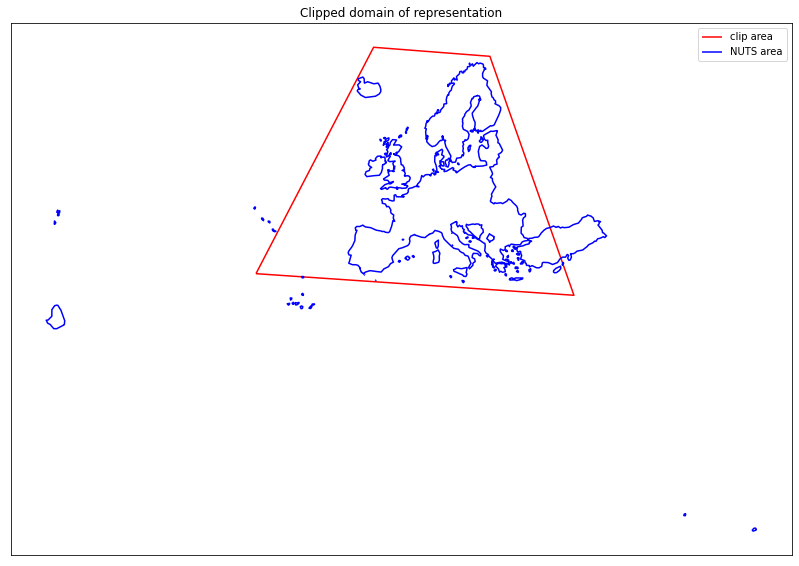

In [32]:
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-25.5, 30.2),
                         (35,  30.2),
                         (35,  71.3),
                         (-25.5, 71.3)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs='EPSG:4326').to_crs('EPSG:3035')

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs='EPSG:3035')


f, ax = mplt.subplots(1, figsize=(14, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
mplt.show()

Following, we use the clip area to crop and represent (on a continuous scale) the results available on continental Europe only (`crop`) distributed at NUTS level `LEVEL`. Missing countries are also represented:<a id='MapAggregated'></a>

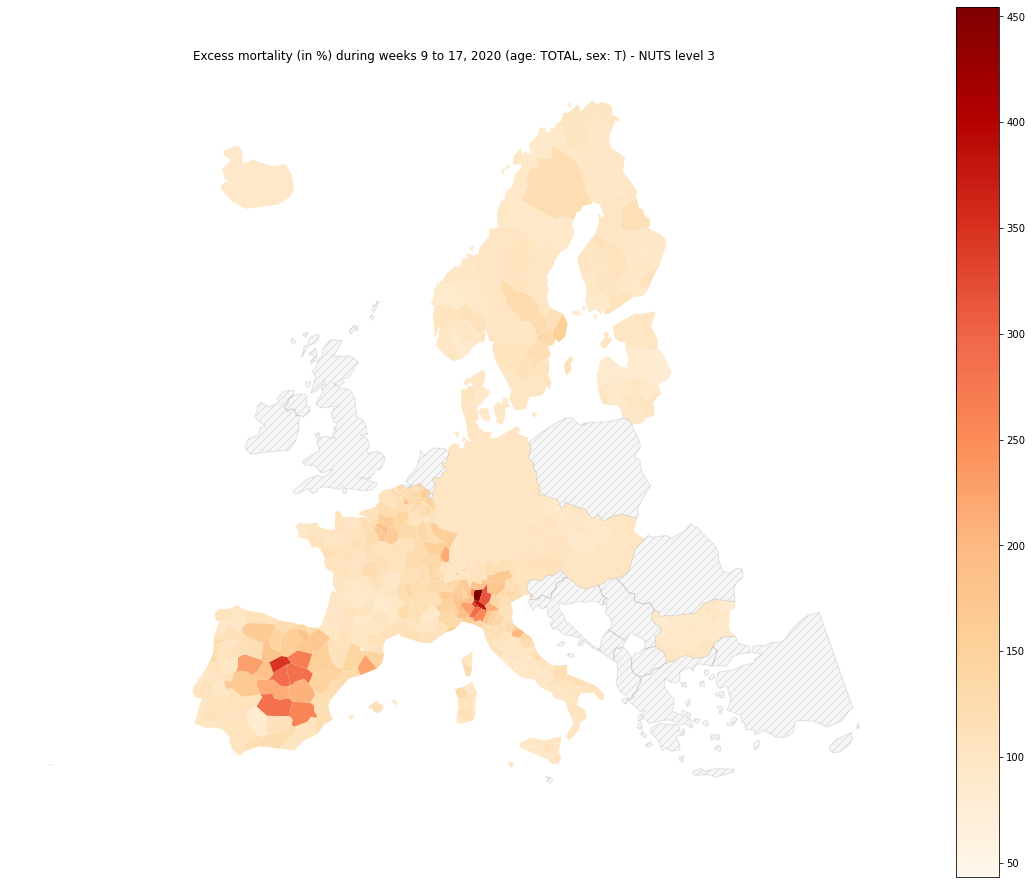

In [33]:
LEVEL = 3
crop = gpd.clip(nuts_death_data[LEVEL], EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

f, ax = mplt.subplots(1, figsize=(20, 16))
crop.plot(column='rinc', ax=ax, cmap='OrRd', legend=True,
          missing_kwds={ "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
ax.set_axis_off()
ax.set_title('Excess mortality (in %%) during weeks %s to %s, %s (age: %s, sex: %s) - NUTS level %s' 
             % (min(WEEKRES), max(WEEKRES), YCUR, AGE, SEX, LEVEL))
mplt.show()

For information, the NUTS data (at various levels, depending on the countries' availability at the selected representation level `LEVEL`) represented in the map above are listed in `INREGIONS`:

In [34]:
INREGIONS = s_death_data['NUTS_ID'].unique().tolist()

print("NUTS regions actually available for this selection: \033[1m%s\033[0m" % INREGIONS)

NUTS regions actually available for this selection: ['AT', 'AT1', 'AT11', 'AT12', 'AT13', 'AT2', 'AT21', 'AT22', 'AT3', 'AT31', 'AT32', 'AT33', 'AT34', 'BE', 'BE1', 'BE10', 'BE100', 'BE2', 'BE21', 'BE211', 'BE212', 'BE213', 'BE22', 'BE221', 'BE222', 'BE223', 'BE23', 'BE231', 'BE232', 'BE233', 'BE234', 'BE235', 'BE236', 'BE24', 'BE241', 'BE242', 'BE25', 'BE251', 'BE252', 'BE253', 'BE254', 'BE255', 'BE256', 'BE257', 'BE258', 'BE3', 'BE31', 'BE310', 'BE32', 'BE321', 'BE322', 'BE323', 'BE324', 'BE325', 'BE326', 'BE327', 'BE33', 'BE331', 'BE332', 'BE334', 'BE335', 'BE336', 'BE34', 'BE341', 'BE342', 'BE343', 'BE344', 'BE345', 'BE35', 'BE351', 'BE352', 'BE353', 'BG', 'BG3', 'BG31', 'BG311', 'BG312', 'BG313', 'BG314', 'BG315', 'BG32', 'BG321', 'BG322', 'BG323', 'BG324', 'BG325', 'BG33', 'BG331', 'BG332', 'BG333', 'BG334', 'BG34', 'BG341', 'BG342', 'BG343', 'BG344', 'BG4', 'BG41', 'BG411', 'BG412', 'BG413', 'BG414', 'BG415', 'BG42', 'BG421', 'BG422', 'BG423', 'BG424', 'BG425', 'CH', 'CH0', 'CH0

### Spatio-temporal visualisations

Likewise the *Statistics Explained* article on [death statistics](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics&stable), we actually the death excess on a weekly basis. The reference shall still be taken as the mean over the previous years starting from 201. For reminder: 

In [35]:
INDICE = 'I100'
BASE = "mean" # "max" # "min"
INC = 'rinc'
AGE, SEX = "TOTAL", "T"
YSTART, YCUR = 2016, 2020 

then we use the previously defined functions to generate the desired datasets (`data`), once per single week (`WEEKRES`) and per single NUTS level (`LEVELS`):

In [36]:
data = dict.fromkeys(WEEKRES)

for w in WEEKRES:
    temp = estimate_excess_mortality(INDICE, death_data, inc = INC, agg = BASE, 
                                     week = w, ystart = YSTART, year = YCUR)
    temp = build_table(temp, inc = INC, key=KEY,
                       age = AGE, sex = SEX, 
                       miss_id = MISSING_CTRY_ID)
    temp = build_unit_level(nuts_data, temp, 
                            levels = LEVELS, key = KEY, how='right') 
    data[w] = propagate_unit_level(temp, levels = LEVELS, 
                                   inc = INC, key = KEY, 
                                   miss_id = MISSING_CTRY_ID)

We display the different estimations together:<a id='Maps'></a> 

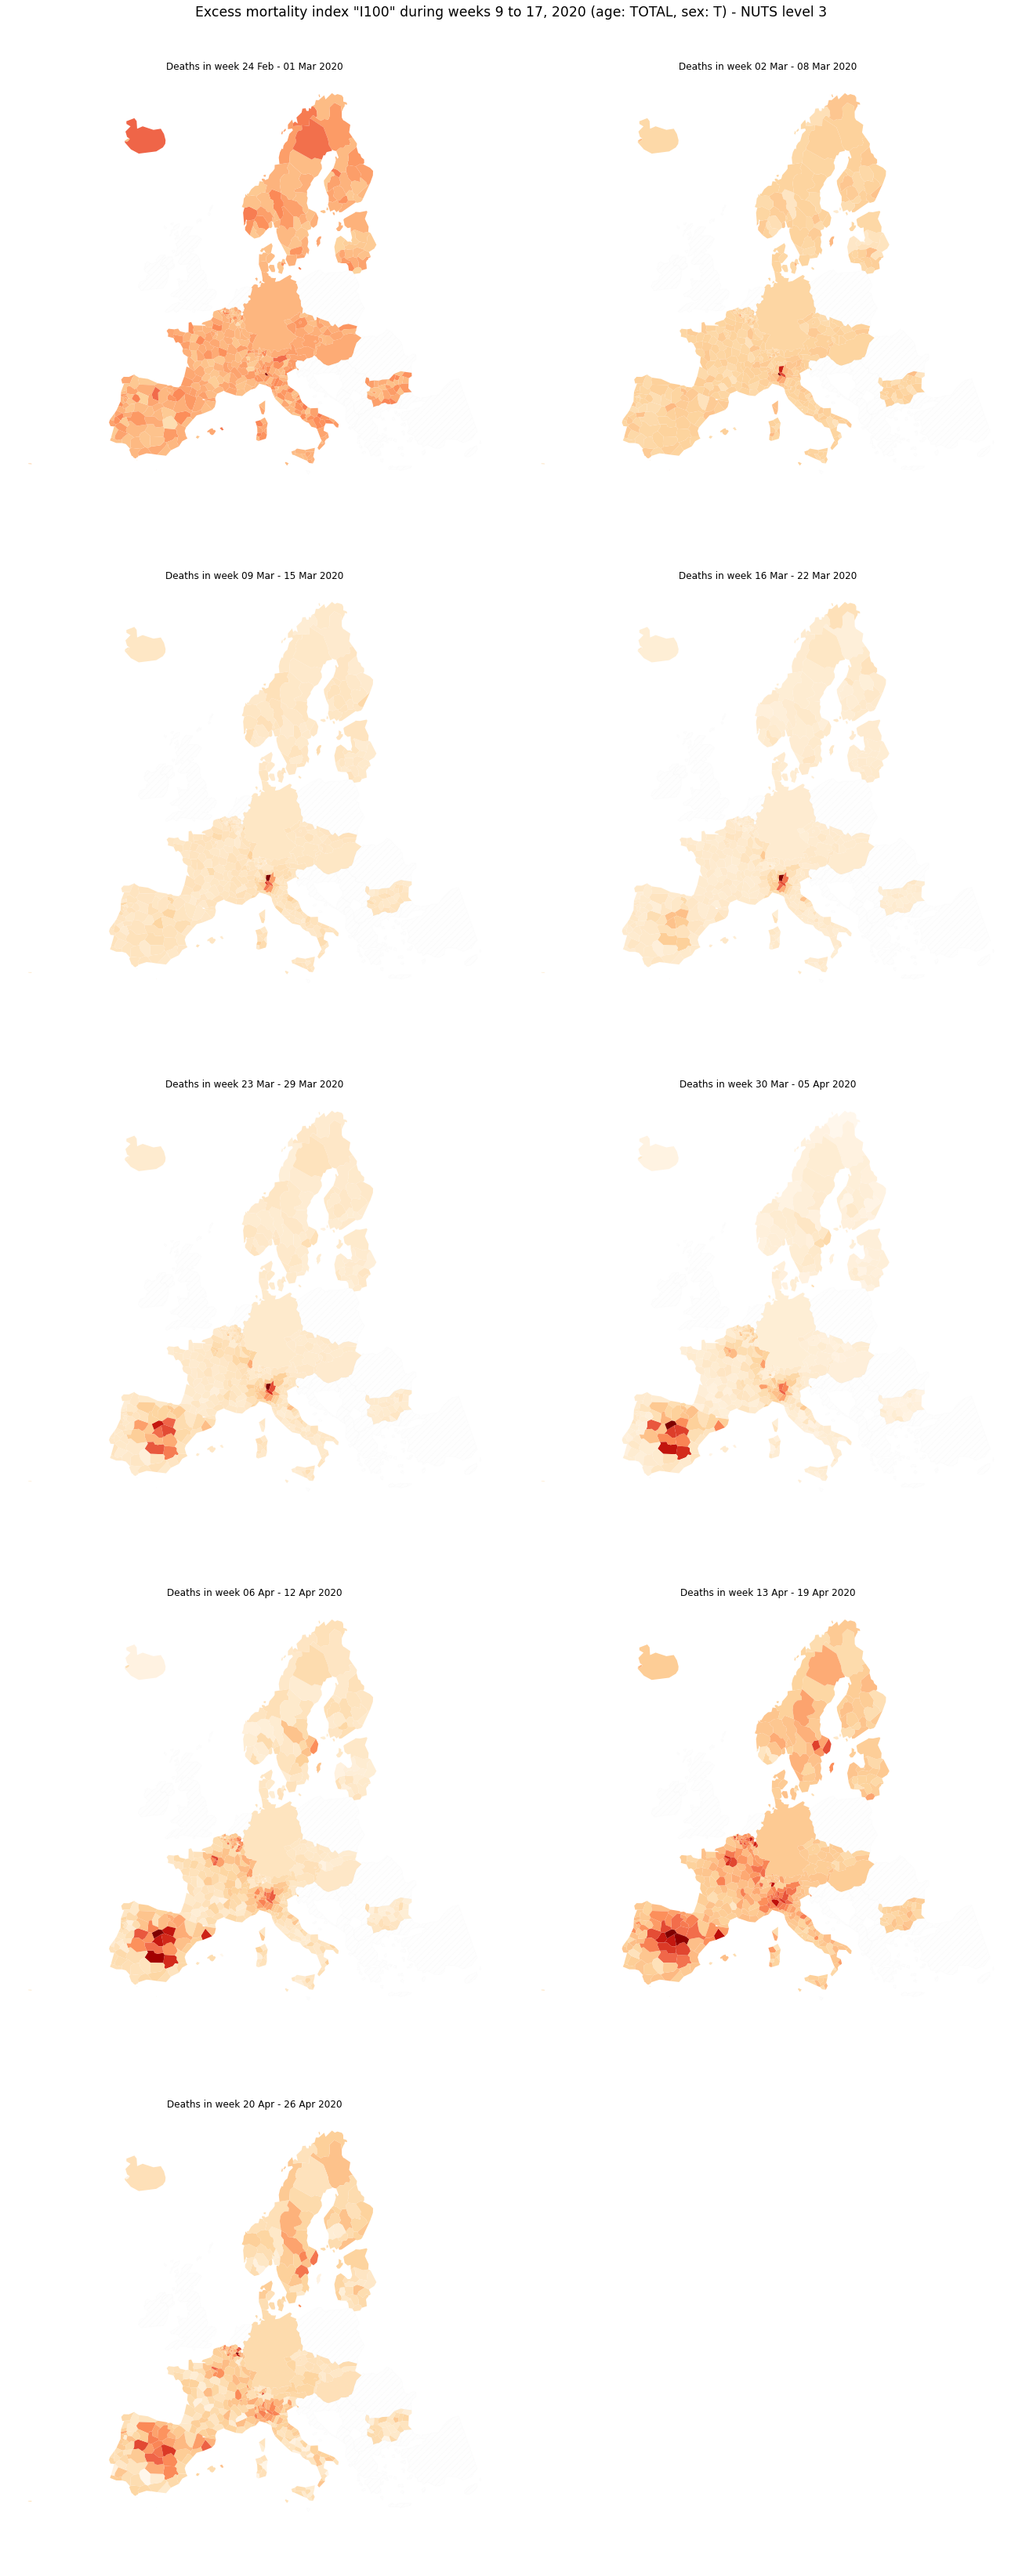

In [37]:
LEVEL = 3

ncols, height = 2, 45
nrows = int(np.ceil(len(WEEKRES) / ncols))
f, ax = mplt.subplots(nrows, ncols, constrained_layout=True,
                      figsize=(int(height*ncols/nrows), height))
nax = nrows * ncols

for i, w in enumerate(WEEKRES):
    x, y = int(i/ncols), i%ncols
    crop = gpd.clip( data[w][LEVEL], EUclip)
    crop.plot(column=INC, ax=ax[x][y], cmap='OrRd', legend=False,
              missing_kwds={ "color": "lightgrey", "alpha": 0.02, "edgecolor": "grey", "hatch": "///"}
             )
    day = '%s-W%s' % (YCUR, w)
    mon, sun = [datetime.strptime(day + '-%s' % d, '%G-W%V-%u').strftime("%d %b") for d in [1,7]]
    ax[x][y].set_axis_off()
    ax[x][y].set_title('Deaths in week %s - %s %s' % (mon, sun, YCUR)) 

for j in range(i+1, nax):
    x, y = int(j/ncols), j%ncols
    ax[x][y].set_axis_off()
    ax[x][y].axes.get_xaxis().set_visible(False); ax[x][y].axes.get_yaxis().set_visible(False)

y_title_pos = ax[0][0].get_position().get_points()[1][1]+(1/nrows)*0.15

suptitle = ('Excess mortality %s during weeks %s to %s, %s (age: %s, sex: %s) - NUTS level %s' 
            % ('index "I100"' if INDICE=='I100' else 'rate', min(WEEKRES), max(WEEKRES), YCUR, AGE, SEX, LEVEL)
           )

f.suptitle(suptitle, y=y_title_pos, fontsize='xx-large')
mplt.show()

Note that in the rendering above, the colormap is not common to the different maps. 

Let's now represent these data "all together". First, we anticipate that we will reproject the data to lat/lon reference system, so we do it once for all:

In [38]:
for w in WEEKRES:
    # for level in LEVELS:
    data[w][LEVEL] = data[w][LEVEL].to_crs('EPSG:4326')

In [39]:
data[9][LEVEL][INC].max()

228.90173410404623

We first build a colormap based on the actual values and whose color values follow the color code adopted in the *Statistics Explained* article:

In [40]:
colors = ((238,208,183), (227,168,127), (219,131,83), (211,98,42), (182,0,0))
colors_index = [nuts_death_data[LEVEL][INC].min(), 100, 200, 300, 400]
vmin = min([int(np.floor(data[w][LEVEL][INC].min())) for w in WEEKRES])
vmax = max([int(np.floor(data[w][LEVEL][INC].max())) for w in WEEKRES])

cmap_nuts = bcm.StepColormap(colors=colors,index=colors_index,
                            vmin=vmin, 
                            vmax=vmax,
                            caption='Death excess index "I100"' if INDICE=='I100' else 'Death excess rate'
                           )

cmap_nuts

Following, we can represent the choropleths (with this common colormap) for the different weeks:<a id='MapsOverlay'></a> 

In [41]:
m = folium.Map((52.3,8.0), zoom_start=4)

def style_function(d_rinc, feature):
    _id = d_rinc.get(feature['properties'][KEY],None)
    return {
        'color':'black',
        'fillColor': '#808080', # '#gray'
        'fillOpacity': 0.1,
        'weight': 0.1,
    } if (_id is None or np.isnan(_id)) else {
        'color':'black',
        'fillColor': cmap_nuts(_id),
        'fillOpacity': 0.9,
        'weight': 0.3,
    } 

def highlight_function(feature):
    return {'fillColor': '#000000', 
            'color':'#000000',
            'fillOpacity': 0.6, 
            'weight': 0.1}

def tooltip():
    return folium.GeoJsonTooltip(fields=[KEY,INC],
            aliases=['NUTS', 'Index "I100"' if INDICE=='I100' else 'Rate (%)'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )

for i, w in enumerate(WEEKRES):
    day = '%s-W%s' % (YCUR, w)
    mon, sun = [datetime.strptime(day + '-%s' % d, '%G-W%V-%u').strftime("%d %b") for d in [1,7]]
    inc_dict = data[w][LEVEL].set_index(KEY)[INC].to_dict()
    folium.GeoJson(
        data = data[w][LEVEL].to_json(),
        name = '%s - %s (#%s)' % (mon, sun, w),
        style_function = functools.partial(style_function, inc_dict),
        highlight_function = highlight_function,
        tooltip = tooltip(),
        show = True if i==0 else False
    ).add_to(m)

folium.LayerControl('topleft', collapsed=False).add_to(m)
cmap_nuts.add_to(m)

m

We can also use the `Choropleth` class of `folium` to represent dynamically the temporal evolution of the death excess rate:<a id='MapsSlider'></a> 

In [42]:
# building a color field
for i, w in enumerate(WEEKRES):
    # inc_dict = data[w][LEVEL].set_index(KEY)[INC].to_dict()
    # data[w][LEVEL]['color'] = (data[w][LEVEL][KEY]).apply(lambda x: cmap_nuts(inc_dict.get(x,None)))
    data[w][LEVEL]['color'] = (data[w][LEVEL][INC]
                               .apply(lambda x: cmap_nuts(x) if ~np.isnan(x) else '#808080')
                              )
    
# value we will iterate in order to create the styledict
dayfirst = datetime.strptime('%s-W%s-1' % (YCUR, WEEKRES[0]), '%G-W%V-%u') #.strftime("%d %b")
dates = (pd.date_range(dayfirst, periods=len(WEEKRES), freq='M').astype(int) // 10**9).astype('U10')
# dates = [datetime.strptime('%s-W%s-1' % (YCUR, w), '%G-W%V-%u') for w in WEEKRES]
nuts_ids = nuts_death_data[LEVEL][KEY].unique().tolist()

# styledict contains for each NUTS ID the timestamp (=week index) and the color to plot
styledict = dict.fromkeys(nuts_ids)

# iterate to populate the styledict: not the most efficient though...
for _id in nuts_ids:
    styledict[_id] = {}
    for i, w in enumerate(WEEKRES):
        color = data[w][LEVEL].loc[data[w][LEVEL][KEY] == _id, 'color'].iloc[0]
        styledict[_id].update({dates[i]: 
                               {'color': color,
                                'opacity': 0.1 if color == '#808080' else 0.9}
                              })

We then create and render the map:

In [43]:
m = folium.Map((52.3,8.0), zoom_start=4)

foliump.TimeSliderChoropleth(
    #data[WEEKRES[0]][LEVEL].set_index(KEY).to_json(),
    nuts_death_data[LEVEL].set_index(KEY).to_crs('EPSG:4326').to_json(), # file with all geometries 
    styledict = styledict
).add_to(m)

cmap_nuts.add_to(m)

m

### Annex - Other possible representations

Using again the `Choropleth` class to represent the aggregated period in `nuts_death_data`:

In [44]:
LEVEL = 3

m = folium.Map((52.3,8.0), zoom_start=4)

dayfirst = datetime.strptime('%s-W%s-1' % (YCUR, WEEKRES[0]), '%G-W%V-%u').strftime("%d %b")
daylast = datetime.strptime('%s-W%s-7' % (YCUR, WEEKRES[-1]), '%G-W%V-%u').strftime("%d %b") 

legend_name = ('Excess death %s: Period %s - %s %s' 
               % ('index "I100"' if INDICE=='I100' else 'rate', dayfirst, daylast, YCUR))

choro = folium.Choropleth(
    name = 'Period %s - %s %s' % (dayfirst, daylast, YCUR),
    legend_name = legend_name,
    geo_data = nuts_death_data[LEVEL].to_crs('EPSG:4326').to_json(), 
    data = nuts_death_data[LEVEL],
    columns=[KEY, INC],
    fill_color='OrRd',
    fill_opacity = 0.9, 
    line_opacity = 0.9,
    nan_fill_color='grey',
    nan_fill_opacity=0.05,
    nan_line_opacity = 0.05,
    key_on='feature.properties.NUTS_ID',
    show=True
).add_to(m)


#folium.LayerControl(collapsed=False).add_to(m)
m

Say that the package `ipyleaflet` is available, you could also display the `nuts_death_data` values:

In [45]:
import ipyleaflet

LEVEL = 3

geo_data = json.loads(nuts_death_data[LEVEL]
                      .dropna(axis='index', subset=[INC]) 
                      .to_crs('EPSG:4326')
                      .to_json()
                     )
choro_data = dict(zip(nuts_death_data[LEVEL].index.astype(str).tolist(), 
                      nuts_death_data[LEVEL][INC]))

m = ipyleaflet.Map(center = (52.3,8.0), zoom = 4)

layer = ipyleaflet.Choropleth(
    geo_data = geo_data,
    choro_data = choro_data,
    colormap = cmap_nuts,
    on_key = 'id',
    style = {'fillOpacity': 1, 'dashArray': '5, 5'},
    name = 'Excess mortality during weeks %s to %s, %s (age: %s, sex: %s) - NUTS level %s' 
             % (min(WEEKRES), max(WEEKRES), YCUR, AGE, SEX, LEVEL)
)

m.add_layer(layer)

m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…